# Hamiltonian:

2 electron spins in PP, 1 radical spin - only 1 of the PP electrons coupled to radical:

$H=H_{ex}+H_{Zee}+H_{zfs}$

The electron spin operators are $\hat{S}_i=(\sigma_x,\sigma_y,\sigma_z)_i$

Take general magnetic field to be: $\mathbf{B}=B_0(cos\phi sin\theta, sin\phi sin\theta, cos\theta)$

Three alternative Hamiltonians in code below.

# Explicit form of `Hams2_eRe1e2_altzfs`:

 
$H=H_{eR}\otimes H_{e1}\otimes H_{e2}$   

Originally had $H=H_{e1}\otimes H_{e2}\otimes H_{eR}$ 

--- 

#### Exchange:

$H_{ex} = H_{ex, PP} + H_{ex, 1R}$

$ H_{ex, PP} = -2 J_{PP} (I \otimes S_x \otimes S_x  + I \otimes S_y \otimes S_y + I \otimes S_z \otimes S_z )$

$ H_{ex, 1R} = -2 J_{R} (S_x \otimes S_x \otimes I  + S_y \otimes S_y \otimes I + S_z \otimes S_z \otimes I  )$ 

For now, only exchange between one spin within radical pair and the gxl (only PCBM has correct energy level resonance)

---

#### Zeeman:

$H_{Zee} = H_{Zee, PP} + H_{Zee, R}$

$ H_{Zee, PP} = g\mu_B\Big(B_x(I\otimes S_x \otimes I+I\otimes I\otimes S_x)+ B_y(I\otimes S_y \otimes I+I\otimes I\otimes S_y)+B_z(I\otimes S_z \otimes I+I\otimes I\otimes S_z)\Big)$

$ H_{Zee, R } = g\mu_B(B_x(S_x\otimes I\otimes I)+ B_y(S_y\otimes I\otimes I)+B_z(S_z\otimes I\otimes I)$

---

#### Zero field splitting:

$H_{zfs, 4x4} = D (S^2_z - \frac{2}{3}I) + E (S^2_x - S^2_y) $

Thinking whether this is appropriate while having singlet in basis (since splitting only within triplet manifold) - but operating in uncoupled so maybe it's fine?

Originally had: $H_{zfs, 8x8} = H_{zfs, 4x4} \otimes I_{2x2} + I_{2x2} \otimes H_{zfs, 4x4} $    

But now think this should be: $H_{zfs, 8x8} = I_{2x2} \otimes H_{zfs, 4x4} $ 

NB: If any term acting only on gxl radical is necessary, need to be of the form: $H_{i, tot, 8x8} = H_{i, gxl, 2x2} \otimes I_{4x4}  $ 


---

# Shelving states:

Add 4 shelving states to the 8-dimenstonal Hilbert space of 3 spins -> 12x12. 

$\rho=(\rho_{eR}\otimes\rho_{e1}\otimes\rho_{e2})\oplus\rho_{shelves}$

The 3-spin states can spin-selectively relax into the singlet and triplet shelving states $\vert S\rangle$ and $\vert T_0 \rangle$, $\vert T_+ \rangle$, $\vert T_- \rangle$. 

The final populations of shelving states gives the singlet and triplet yields.

---

# Projectors:

12x12- project 3-spin singlet/triplet states to recombination shelves

$P_1=\vert S\rangle\langle s\alpha\vert$

$P_2=\vert T_0\rangle\langle t_0\alpha\vert$

$P_3=\vert T_+\rangle\langle t_+\alpha\vert$

$P_4=\vert T_-\rangle\langle t_-\alpha\vert$

$P_5=\vert S\rangle\langle s\beta\vert$

$P_6=\vert T_0\rangle\langle t_0\beta\vert$

$P_7=\vert T_+\rangle\langle t_+\beta\vert$

$P_8=\vert T_-\rangle\langle t_-\beta\vert$

---

# Basis:

Given projectors need basis kets (left to right):

$\vert \uparrow\uparrow\alpha\rangle, \vert \uparrow\downarrow\alpha\rangle,\vert \downarrow\uparrow\alpha\rangle, \vert \downarrow\downarrow\alpha\rangle, \vert \uparrow\uparrow\beta\rangle, \vert \uparrow\downarrow\beta\rangle,\vert \downarrow\uparrow\beta\rangle, \vert \downarrow\downarrow\beta\rangle $

The arrows refer to spins on the polaron pair (in the uncoupled representation), and alpha/beta is the spin of the gxl radical.

---


# Initial states:

Initially radical pair is in singlet state: $\vert s\rangle=\frac{1}{\sqrt{2}}(\vert\uparrow\downarrow\rangle-\vert\downarrow\uparrow\rangle)$ ("optical pumping").

Take initially mixed state of gxl, so overall initial density matrix: $\rho(0)=\vert s\alpha\rangle\langle s\alpha\vert+\vert s\beta\rangle\langle s\beta\vert$

Alternative initial state is a normalised linear combination of all 8 singlet/triplet states with equal occupations ("electrical pumping").

---

# Lindblad Master Equation:

$\partial_t\rho=-\frac{i}{\hbar}[H,\rho]+k\sum^8_{i=1}{\Big(P_i\rho P^\dagger_i}-\frac{1}{2}(P^\dagger_iP_i\rho+\rho P^\dagger_iP_i)\Big)$

First term is unitary evolution, the remaining is recombination.

In [53]:
# adapted from gxl v.0.1.1

####################################################################################
# Preamble:
####################################################################################
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.linalg import block_diag as bd
import pandas as pd
import os

####################################################################################
# Plotting function: 
####################################################################################
def plotres2(res, bvect, consts, k, fig=False, save=False):
    """Converts output of mesolve to dataarray of populations and generates figure"""
    Spop,T0pop,Tppop,Tnpop=[],[],[],[]
    for i in range(len(res.states)):
        Spop.append(np.real(res.states[i][8,8]))
        T0pop.append(np.real(res.states[i][9,9]))
        Tppop.append(np.real(res.states[i][10,10]))
        Tnpop.append(np.real(res.states[i][11,11]))
    Spop,T0pop,Tppop,Tnpop=np.array(Spop),np.array(T0pop),np.array(Tppop),np.array(Tnpop)
    Ttot=T0pop+Tppop+Tnpop
    Spopn,Ttotn,tn,T0popn = Spop[1:],Ttot[1:],t[1:],T0pop[1:]
    ratio=(Spopn-Ttotn)/(Spopn+Ttotn)*100
    T0frac=(T0popn)/(Ttotn)*100    
    dataarray = pd.DataFrame(np.stack([Spop[1:],Ttot[1:],T0pop[1:],Tppop[1:],Tnpop[1:],ratio,T0frac], axis=1),index=t[1:],columns=['Spop','Ttot','T0pop','T+pop','T-pop','ratio','T0frac'])
    if fig==True:
        fig, ([ax1,ax3],[ax2,ax4]) = plt.subplots(2,2,figsize=(11,7))
        suptit=f"B field xyz = [{np.format_float_scientific(bvect[0], precision=2)},   {np.format_float_scientific(bvect[1], precision=2)},   {np.format_float_scientific(bvect[2], precision=2)}] T \n J_r = {consts[0]:.3e} ; J_pp = {consts[1]:.3e} ; D = {consts[2]:.3e} ; E = {consts[3]:.3e} mT \n k = {k} GHz"
        fig.suptitle(suptit)
        ax1.plot(t,Spop,'.-',label='S pop')
        ax1.plot(t,Ttot,'.-',label='T pop')
        ax1.plot(t,T0pop,'-',label='T0 pop')
        ax1.plot(t,Tppop,'-',label='T+ pop')
        ax1.plot(t,Tnpop,'-',label='T- pop')
        ax1.set_ylabel('level population')
        ax1.legend()
        ax2.plot(tn,ratio,label='% S excess')
        ax2.plot(tn,T0frac,label='% T0 in T')
        ax2.axhline(y=0,c='grey')
        ax2.legend()
        ax2.set_ylabel('%')
        ax2.set_xlabel('time / ns')
        ax3.semilogx(t,Spop,'.-',label=f"S pop fin = {Spop[-1]:.3f}")
        ax3.semilogx(t,Ttot,'.-',label=f"T pop fin = {Ttot[-1]:.3f}")
        ax3.semilogx(t,T0pop,'-',label=f"T0 pop fin = {T0pop[-1]:.3f}")
        ax3.semilogx(t,Tppop,'-',label=f"T+ pop fin = {Tppop[-1]:.3f}")
        ax3.semilogx(t,Tnpop,'-',label=f"T- pop fin = {Tnpop[-1]:.3f}")
        ax3.plot(0,0,lw=0,label=f"tot pp final = {(Spop[-1]+Ttot[-1]):.3f}")
        ax3.legend()
        ax4.semilogx(tn,ratio,label=f"% S excess fin = {ratio[-1]:.2f}")
        ax4.semilogx(tn,T0frac,label=f"% T0 in T fin = {T0frac[-1]:.2f}")
        ax4.axhline(y=0,c='grey')
        ax4.set_xlabel('time / ns')
        ax4.legend()
        if save==True:
            nam = f"J_r_{consts[0]:.3e} ; J_pp_{consts[1]:.3e} ; D_{consts[2]:.3e} ; Bz_{bvect[2]:.3e}"
            plt.savefig((nam+'.png'),dpi=300)
            #dataarray.to_csv((nam+'.csv'))
        plt.show()
    return dataarray

####################################################################################
# Conversion functions:
####################################################################################

def mTtoGHz(x):
    return 0.02802495*x

def Bfield(Ba0,p,t):
    return np.array([Ba0*np.cos(p)*np.sin(t), Ba0*np.sin(p)*np.sin(t), Ba0*np.cos(t)])

def dfsetindex(dflist, ixarray, ixtitle):
    newdfs = []
    for i in dflist:
        d = i.set_index(ixarray)
        d.index.name = ixtitle
        newdfs.append(d)
    return newdfs

def scale_ops(ops,k):
    """ Scales projection operators by recombination constant k """
    newops=[]
    for i in range(len(ops)):
        newops.append(k*ops[i])
    return newops

In [32]:
####################################################################################
# Pauli operators:
#################################################################################### 

Sx=sigmax()/2
Sy=sigmay()/2
Sz=sigmaz()/2
I=qeye(2)

####################################################################################
# Projectors:
#################################################################################### 

### NB: Operating in uncoupled representation (so s and t0 are explicitly linear combinations of up/down in projectors)

P1,P2,P3,P4,P5,P6,P7,P8=np.zeros((12,12)),np.zeros((12,12)),np.zeros((12,12)),np.zeros((12,12)),np.zeros((12,12)),np.zeros((12,12)),np.zeros((12,12)),np.zeros((12,12))

P1[8,1]=1; P1[8,2]=-1   #s  alpha   # should this matrix be normalised?
P2[9,1]=1; P2[9,2]=1    #t0 alpha   # should this matrix be normalised?
P3[10,0]=1              #t+ alpha
P4[11,3]=1              #t- alpha
P5[8,5]=1; P5[8,6]=-1   #s  beta    # should this matrix be normalised?
P6[9,5]=1; P6[9,6]=1    #t0 beta    # should this matrix be normalised?
P7[10,4]=1              #t+ beta
P8[11,7]=1              #t- beta

P1,P2,P3,P4,P5,P6,P7,P8=Qobj(P1),Qobj(P2),Qobj(P3),Qobj(P4),Qobj(P5),Qobj(P6),Qobj(P7),Qobj(P8)
c_ops = [P1,P2,P3,P4,P5,P6,P7,P8]
c_norm = [P1.unit(),P2.unit(),P3,P4,P5.unit(),P6.unit(),P7,P8]  

In [126]:
####################################################################################
# Hamiltonian(s):
####################################################################################

def Hams2(J_r, J_pp, D, E, bvect, mu_B):
    
    """ Original Hamiltonian - now think form of zfs and order of states in tensors is wrong. """
    
    # 3 spin system: e1 and e2 PP + eR gxl - order: tensor(e1,e2,eR)         
    
    # exchange
    H_ex_r = -2*J_r*(tensor(Sx,I,Sx)+tensor(Sy,I,Sy)+tensor(Sz,I,Sz))        # exchange e1 coupled to eR only
    H_ex_pp = -2*J_pp*(tensor(Sx,Sx,I)+tensor(Sy,Sy,I)+tensor(Sz,Sz,I))      # exchange e1 coupled to e2  
    H_ex = H_ex_r + H_ex_pp
    
    # Zeeman
    g=2                                                                      # assume all spins same g value 
    [Bx, By, Bz] = bvect                   
    H_Zee_pp = g*mu_B*(Bx*(tensor(I,Sx,I)+tensor(Sx,I,I))+By*(tensor(I,Sy,I)+tensor(Sy,I,I))+Bz*(tensor(I,Sz,I)+tensor(Sz,I,I)))                                                         
    H_Zee_r = g*mu_B*(Bx*tensor(I,I,Sx)+By*tensor(I,I,Sy)+Bz*tensor(I,I,Sz))  
    H_Zee = H_Zee_pp + H_Zee_r
    
    # zfs
    H_zfs = D*(tensor(Sz,Sz)-2.0/3.0*(tensor(I,I)))+E*(tensor(Sx,Sx)-tensor(Sy,Sy))
    H_zfs2 = tensor(I,H_zfs)+tensor(H_zfs,I)                             
    
    # total
    H = H_ex + H_Zee + H_zfs2
    
    null4 = np.zeros((4,4))
    return Qobj(bd(H,null4))

def Hams2_eRe1e2_altzfs(J_r, J_pp, D, E, bvect, mu_B):
    
    """ Alternative Hamiltonian - tensor order changed and zfs acts only on PP """
             
    # swapped order from e1e2eR to eRe1e2
    # zfs acts only on pp
    
    # exchange
    H_ex_r = -2*J_r*(tensor(Sx,Sx,I)+tensor(Sy,Sy,I)+tensor(Sz,Sz,I))        # exchange e1 coupled to eR only
    H_ex_pp = -2*J_pp*(tensor(I,Sx,Sx)+tensor(I,Sy,Sy)+tensor(I,Sz,Sz))      
    H_ex = H_ex_r + H_ex_pp
    
    # Zeeman
    g=2                                                                      # assume all spins same g value 
    [Bx, By, Bz] = bvect                   
    H_Zee_pp = g*mu_B*(Bx*(tensor(I,Sx,I)+tensor(I,I,Sx))+By*(tensor(I,Sy,I)+tensor(I,I,Sy))+Bz*(tensor(I,Sz,I)+tensor(I,I,Sz)))                                                         
    H_Zee_r = g*mu_B*(Bx*tensor(Sx,I,I)+By*tensor(Sy,I,I)+Bz*tensor(Sz,I,I))  
    H_Zee = H_Zee_pp + H_Zee_r
    
    # zfs?
    H_zfs = D*(tensor(Sz,Sz)-2.0/3.0*(tensor(I,I)))+E*(tensor(Sx,Sx)-tensor(Sy,Sy))
    H_zfs2 = tensor(I,H_zfs)
    
    # total
    H = H_ex + H_Zee + H_zfs2
    
    null4 = np.zeros((4,4))
    return Qobj(bd(H,null4))

def Hams2_eRe1e2_altzfs_doubleJr(J_r, J_pp, D, E, bvect, mu_B):
    
    """ Alternative Hamiltonian with gxl exchange to both PP spins """
    
    # swapped order from e1e2eR to eRe1e2
    # zfs acts only on pp  
    # exchange between radical and both spins within pair
    
    # exchange
    H_ex_r = -2*J_r*(tensor(Sx,Sx,I)+tensor(Sy,Sy,I)+tensor(Sz,Sz,I)+tensor(Sx,I,Sx)+tensor(Sy,I,Sy)+tensor(Sz,I,Sz))          
    H_ex_pp = -2*J_pp*(tensor(I,Sx,Sx)+tensor(I,Sy,Sy)+tensor(I,Sz,Sz))      
    H_ex = H_ex_r + H_ex_pp
    
    # Zeeman
    g=2                                                                      # assume all spins same g value
    [Bx, By, Bz] = bvect                   
    H_Zee_pp = g*mu_B*(Bx*(tensor(I,Sx,I)+tensor(I,I,Sx))+By*(tensor(I,Sy,I)+tensor(I,I,Sy))+Bz*(tensor(I,Sz,I)+tensor(I,I,Sz)))                                                         
    H_Zee_r = g*mu_B*(Bx*tensor(Sx,I,I)+By*tensor(Sy,I,I)+Bz*tensor(Sz,I,I))  
    H_Zee = H_Zee_pp + H_Zee_r
    
    # zfs
    H_zfs = D*(tensor(Sz,Sz)-2.0/3.0*(tensor(I,I)))+E*(tensor(Sx,Sx)-tensor(Sy,Sy))
    H_zfs2 = tensor(I,H_zfs)
    
    # total
    H = H_ex + H_Zee + H_zfs2
    
    null4 = np.zeros((4,4))
    return Qobj(bd(H,null4))

####################################################################################
# Initial states:
####################################################################################

# singlet initial state
psi0a=((fock(12,1)-fock(12,2)).unit()+(fock(12,5)-fock(12,6)).unit()).unit()                      

# mixed initial state
psi0b=((fock(12,1)-fock(12,2)).unit()+(fock(12,5)-fock(12,6)).unit()+      # 2 s    states
       (fock(12,1)+fock(12,2)).unit()+(fock(12,5)+fock(12,6)).unit()+      # 2 t0   states
        fock(12,0)+fock(12,3)+fock(12,4)+fock(12,7)).unit()                # 4 t+/- states


In [127]:
print(psi0a)    # singlet

Quantum object: dims = [[12], [1]], shape = (12, 1), type = ket
Qobj data =
[[ 0. ]
 [ 0.5]
 [-0.5]
 [ 0. ]
 [ 0. ]
 [ 0.5]
 [-0.5]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]
 [ 0. ]]


In [118]:
print(psi0b)    # mixed

Quantum object: dims = [[12], [1]], shape = (12, 1), type = ket
Qobj data =
[[0.35355339]
 [0.5       ]
 [0.        ]
 [0.35355339]
 [0.35355339]
 [0.5       ]
 [0.        ]
 [0.35355339]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


In [97]:
####################################################################################
# Calculation function:
####################################################################################

def runcalc2(Ham, consts, bvect, mu_B, t, k, psi0, c_ops, fig=False, save=False):
    
    [J_r, J_pp, D, E] = mTtoGHz(np.array(consts))            # unit conversion

    if Ham == 'original':                                    # choose and compute Hamiltonian
        H2=Hams2(J_r, J_pp, D, E, bvect, mu_B)
    elif Ham == 'eRe1e2_altzfs':
        H2=Hams2_eRe1e2_altzfs(J_r, J_pp, D, E, bvect, mu_B)
    elif Ham == 'eRe1e2_altzfs_doubleJr':
        H2=Hams2_eRe1e2_altzfs_doubleJr(J_r, J_pp, D, E, bvect, mu_B)

    c_new = scale_ops(c_ops, k)                              # compute recombination projectors
    res = mesolve(H2, psi0, t, c_new)                        # compute master equation
    dataarray = plotres2(res, bvect, consts, k, fig, save)   # compute populations
    return dataarray

In [103]:
####################################################################################
# Parameters:
####################################################################################

mu_B = 13.99624493           # GHz/T
bz = 0                       # T
k = 0.1                      # GHz
t=np.logspace(-1,3,2000)     # ns  

D = 10                       # mT  (converted to GHz in runcalc2)
E = D/10.0                   # mT  (converted to GHz in runcalc2)
J_r = 1                      # mT  (converted to GHz in runcalc2)
J_pp= 1                      # mT  (converted to GHz in runcalc2)

consts = [J_r, J_pp, D, E] 
bvect  = [0, 0, bz]  

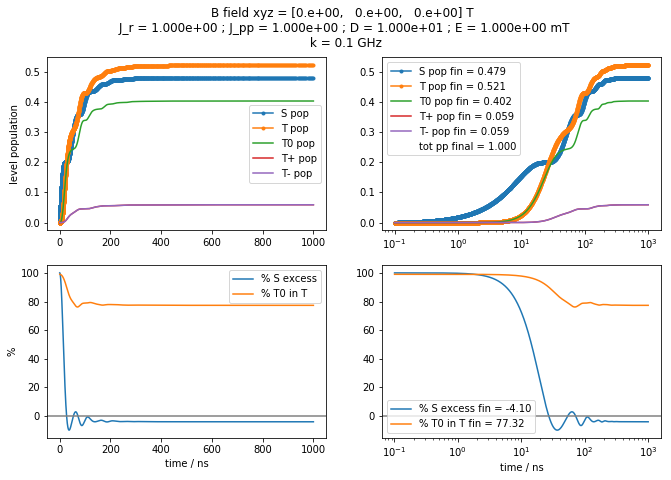

In [129]:
####################################################################################
# Example calculations:
####################################################################################

# Original Hamiltonian with unnormalised projectors:

r = runcalc2('original', consts, bvect, mu_B, t, k, psi0a, c_ops, fig=1, save=0) 

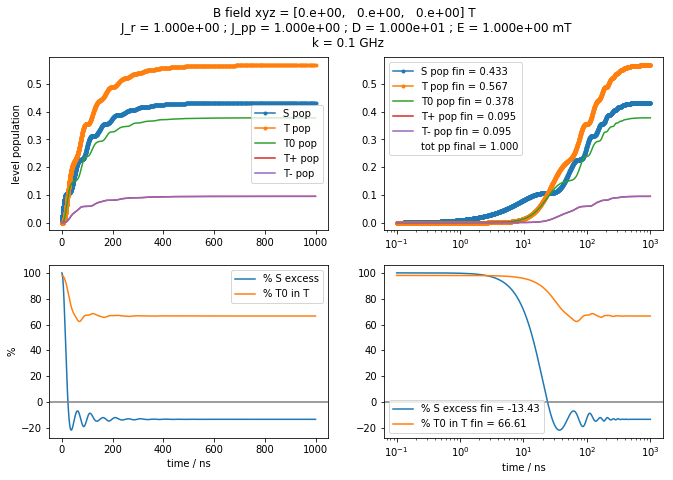

In [130]:
# Original Hamiltonian with normalised projectors:

r = runcalc2('original', consts, bvect, mu_B, t, k, psi0a, c_norm, fig=1, save=0)  

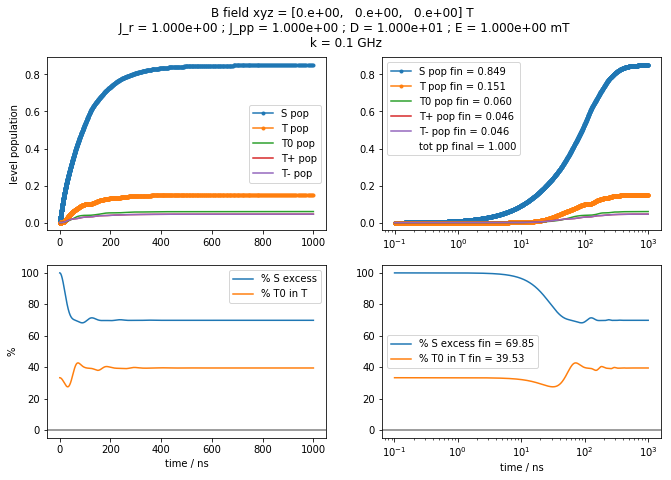

In [131]:
# Updated Hamiltonian with normalised projectors:

r = runcalc2('eRe1e2_altzfs', consts, bvect, mu_B, t, k, psi0a, c_norm, fig=1, save=0)

C:\python\Anaconda\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


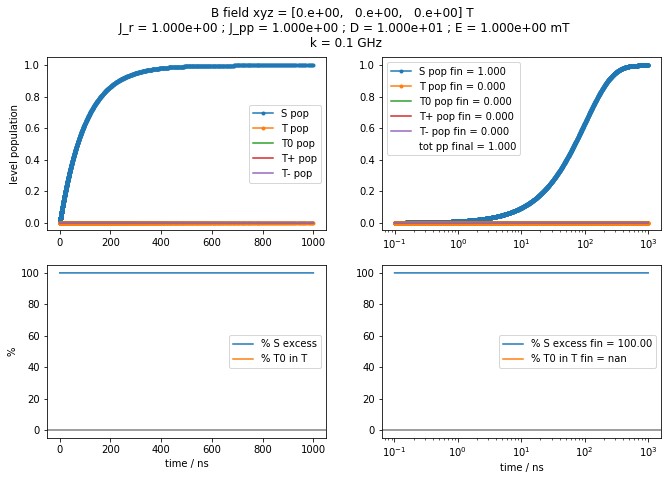

In [132]:
# Updated double gxl exchange Hamiltonian with normalised projectors:

r = runcalc2('eRe1e2_altzfs_doubleJr', consts, bvect, mu_B, t, k, psi0a, c_norm, fig=1, save=0) 

### for a singlet psi0, always give pure singlet regardless of any change to B, J_r, J_pp 
### for a mixed psi0, always gives S:T 0.25:0.75, but with different T0/T+/T- distributions depending on B, J_r, J_pp

In [73]:
####################################################################################
# NB: Example of how tensor products work in QuTiP:
#################################################################################### 

I = qeye(2)
A = Qobj(np.matrix([[20,21],[22,23]]))
B = Qobj(np.matrix([[30,31],[32,33]]))

In [61]:
tensor(A,I)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[20.  0. 21.  0.]
 [ 0. 20.  0. 21.]
 [22.  0. 23.  0.]
 [ 0. 22.  0. 23.]]

In [62]:
tensor(I,A)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[20. 21.  0.  0.]
 [22. 23.  0.  0.]
 [ 0.  0. 20. 21.]
 [ 0.  0. 22. 23.]]

In [63]:
tensor(I,I,A)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[20. 21.  0.  0.  0.  0.  0.  0.]
 [22. 23.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 20. 21.  0.  0.  0.  0.]
 [ 0.  0. 22. 23.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 20. 21.  0.  0.]
 [ 0.  0.  0.  0. 22. 23.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 20. 21.]
 [ 0.  0.  0.  0.  0.  0. 22. 23.]]

In [64]:
tensor(I,A,A)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[400. 420. 420. 441.   0.   0.   0.   0.]
 [440. 460. 462. 483.   0.   0.   0.   0.]
 [440. 462. 460. 483.   0.   0.   0.   0.]
 [484. 506. 506. 529.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 400. 420. 420. 441.]
 [  0.   0.   0.   0. 440. 460. 462. 483.]
 [  0.   0.   0.   0. 440. 462. 460. 483.]
 [  0.   0.   0.   0. 484. 506. 506. 529.]]

In [67]:
tensor(B,A)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[600. 630. 620. 651.]
 [660. 690. 682. 713.]
 [640. 672. 660. 693.]
 [704. 736. 726. 759.]]

In [68]:
tensor(A,B)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[600. 620. 630. 651.]
 [640. 660. 672. 693.]
 [660. 682. 690. 713.]
 [704. 726. 736. 759.]]

In [106]:
tensor(A,qeye(4))

Quantum object: dims = [[2, 4], [2, 4]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[20.  0.  0.  0. 21.  0.  0.  0.]
 [ 0. 20.  0.  0.  0. 21.  0.  0.]
 [ 0.  0. 20.  0.  0.  0. 21.  0.]
 [ 0.  0.  0. 20.  0.  0.  0. 21.]
 [22.  0.  0.  0. 23.  0.  0.  0.]
 [ 0. 22.  0.  0.  0. 23.  0.  0.]
 [ 0.  0. 22.  0.  0.  0. 23.  0.]
 [ 0.  0.  0. 22.  0.  0.  0. 23.]]

In [107]:
tensor(qeye(4),A)

Quantum object: dims = [[4, 2], [4, 2]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[20. 21.  0.  0.  0.  0.  0.  0.]
 [22. 23.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 20. 21.  0.  0.  0.  0.]
 [ 0.  0. 22. 23.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 20. 21.  0.  0.]
 [ 0.  0.  0.  0. 22. 23.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 20. 21.]
 [ 0.  0.  0.  0.  0.  0. 22. 23.]]